# Newsvendor Using LDR Package

In [1]:
using Distributions
using Plots
using JSON
using JuMP
using HiGHS
using Statistics
using Random
using LinearDecisionRules
using LinearAlgebra

In [2]:
buy_cost = 10
return_value = 8
sell_value = 15

demand_max = 120
demand_min = 80

ldr = LinearDecisionRules.LDRModel(HiGHS.Optimizer)
set_silent(ldr)

@variable(ldr, buy >= 0, LinearDecisionRules.FirstStage)
@variable(ldr, sell >= 0)
@variable(ldr, ret >= 0)
@variable(ldr, demand in LinearDecisionRules.Uncertainty(
        distribution = Uniform(demand_min, demand_max)
    )
)

@constraint(ldr, sell + ret <= buy)
@constraint(ldr, sell <= demand)

@objective(ldr, Max,
    - buy_cost * buy
    + return_value * ret
    + sell_value * sell
)

optimize!(ldr)

@show objective_value(ldr)
@show LinearDecisionRules.get_decision(ldr, buy)
@show LinearDecisionRules.get_decision(ldr, buy, demand)
@show LinearDecisionRules.get_decision(ldr, sell)
@show LinearDecisionRules.get_decision(ldr, sell, demand)

@show objective_value(ldr, dual = true)
@show LinearDecisionRules.get_decision(ldr, buy, dual = true)

objective_value(ldr) = 460.0
LinearDecisionRules.get_decision(ldr, buy) = 120.0
LinearDecisionRules.get_decision(ldr, buy, demand) = 0.0
LinearDecisionRules.get_decision(ldr, sell) = 0.0
LinearDecisionRules.get_decision(ldr, sell, demand) = 1.0
objective_value(ldr, dual = true) = 486.66666666666663
LinearDecisionRules.get_decision(ldr, buy, dual = true) = 106.6666666666667


106.6666666666667

## Extending problem to piecewise version

### Copy necessary data

In [3]:
ABC = ldr.ext[:_LDR_ABC]

ABC_copy = deepcopy(ABC)
ABC_data = (; 
    Ae = ABC_copy.Ae,
    Be = ABC_copy.Be,
    Au = ABC_copy.Au,
    Bu = ABC_copy.Bu,
    Wu = ABC_copy.Wu,
    ub = ABC_copy.ub,
    hu = ABC_copy.hu,
    Al = ABC_copy.Al,
    Bl = ABC_copy.Bl,
    Wl = ABC_copy.Wl,
    lb = ABC_copy.lb,
    hl = ABC_copy.hl,
    C  = ABC_copy.C,
    xu = ABC_copy.xu,
    xl = ABC_copy.xl
)

(Ae = sparse(Int64[], Int64[], Float64[], 0, 3), Be = sparse(Int64[], Int64[], Float64[], 0, 2), Au = sparse([1, 1, 2, 1], [1, 2, 2, 3], [-1.0, 1.0, 1.0, 1.0], 2, 3), Bu = sparse([2], [2], [1.0], 2, 2), Wu = sparse(Int64[], Int64[], Float64[], 0, 1), ub = [120.0], hu = Float64[], Al = sparse(Int64[], Int64[], Float64[], 0, 3), Bl = sparse(Int64[], Int64[], Float64[], 0, 2), Wl = sparse(Int64[], Int64[], Float64[], 0, 1), lb = [80.0], hl = Float64[], C = sparse([1, 2, 3], [1, 1, 1], [-10.0, 15.0, 8.0], 3, 2), xu = [Inf, Inf, Inf], xl = [0.0, 0.0, 0.0])

### Functions to convert problem

In [29]:
function build_B(B, eta_min, n_breakpoints)
    first_column = B[:,1]
    second_column = B[:,2]
    B_new = zeros(size(B)[1], n_breakpoints + 1)
    B_new[:,1] = first_column + second_column * eta_min
    for j in 2:(n_breakpoints + 1)
        B_new[:, j] = second_column
    end

    return B_new
end

function build_W(W, eta_min, n_breakpoints)
    W_new = zeros(size(W)[1], n_breakpoints + 1)
    for j in 1:(n_breakpoints + 1)
        W_new[:, j] = W
    end

    return W_new
end

function build_C(C, eta_min, n_breakpoints)
    first_column = C[:,1]
    second_column = C[:,2]
    C_new = zeros(size(C)[1], n_breakpoints + 1)
    C_new[:,1] = first_column + second_column * eta_min
    for j in 2:(n_breakpoints + 1)
        C_new[:, j] = second_column
    end

    return C_new
end

function build_h(h, W, eta_min)
    return h - W*eta_min
end

function build_eta_inequalities(n_breakpoints, eta_min, eta_max)
    diff = (eta_max - eta_min) / (n_breakpoints)

    # 2 for "1" in (1, n), and 1 for extreme of inequalities
    W = zeros(n_breakpoints + 1 + 2, n_breakpoints + 1)
    W[1,1] = 1
    W[2,1] = -1

    h = zeros(n_breakpoints + 1 + 2)
    h[1] = 1
    h[2] = -1
    h[3] = 1

    for i in 3:(n_breakpoints + 2)
        W[i, i - 1] = 1/diff
        W[i + 1, i - 1] = -1/diff
    end

    W[n_breakpoints + 3, n_breakpoints + 1] = -1/diff

    return W, h
end

function build_second_moment_matrix(n_breakpoints, eta_min, eta_max)
    Δ = zeros(n_breakpoints)

    eta_tilde = zeros(n_breakpoints + 1)
    eta_tilde[1] = eta_min

    M = zeros(n_breakpoints + 1, n_breakpoints + 1)

    var_unif = Uniform(eta_min, eta_max)

    p_accum = zeros(n_breakpoints + 1)
    expec_delta = zeros(n_breakpoints)
    second_moment = zeros(n_breakpoints)

    diff = (eta_max - eta_min) / (n_breakpoints)
    for i in 2:(n_breakpoints + 1)
        eta_tilde[i] = eta_min + diff * (i - 1)
        Δ[i - 1] = eta_tilde[i] - eta_tilde[i - 1]
        demand_delta = Uniform(eta_tilde[i - 1], eta_tilde[i])
        expec_delta[i - 1] = mean(demand_delta)
        second_moment[i - 1] = var(demand_delta) + expec_delta[i - 1]^2
    end
    eta_tilde[n_breakpoints + 1] = eta_max

    for i in 1:(n_breakpoints + 1)
        p_accum[i] = cdf(var_unif, eta_tilde[i])
    end

    # Xi0
    M[1,1] = 1
    for i in 2:(n_breakpoints + 1)
        M[1, i] = expec_delta[i - 1]
        M[i, 1] = expec_delta[i - 1]
    end

    # Xi breakpoints i < j, i > j
    for i in 2:(n_breakpoints + 1)
        for j in (i+1):(n_breakpoints + 1)
            value = Δ[i - 1]*Δ[j - 1]*p_accum[j] + Δ[i - 1] * expec_delta[j - 1]
            M[i, j] = value
            M[j, i] = value
        end
    end

    # Xi breakpoints i = j
    for i in 2:(n_breakpoints + 1)
        M[i, i] = Δ[i - 1]^2 * p_accum[i] + second_moment[i - 1] - 2 * eta_tilde[i - 1] + eta_tilde[i-1]^2 * (p_accum[i] - p_accum[i - 1])
    end

    return M
end

function solve_problem(n_breakpoints, eta_min, eta_max, ABC_data)
    # This function doesn't solve a generic problem, only works for this problem
    if (n_breakpoints < 1)
        println("Número de breakpoints deve ser maior que 1")
        return
    end

    model = Model(HiGHS.Optimizer)
    
    dim_x = size(ABC.Ae, 2)
    dim_ξ = 1 + n_breakpoints

    @variable(model, X[1:dim_x, 1:dim_ξ] >= 0)

    # Equality constraints
    if size(ABC_data.Be, 1) > 0
        Be = build_B(ABC_data.Be, eta_min, n_breakpoints)
        @constraint(model, ABC.Ae * X .== Be)
    end

    W, h = build_eta_inequalities(n_breakpoints, eta_min, eta_max)
    nW = size(W, 1)
    
    # Inequality contraints
    if size(ABC_data.Bu, 1) > 0
        Bu = build_B(ABC_data.Bu, eta_min, n_breakpoints)
        @variable(model, Su[1:size(Bu, 1), 1:dim_ξ])
        @constraint(model, ABC.Au * X .+ Su .== Bu)
        @variable(model, ΛSu[1:size(Bu, 1),1:nW] >= 0)
        @constraint(model, ΛSu * W .== Su)
        @constraint(model, ΛSu * h .>= 0)
    end

    if size(ABC_data.Bl, 1) > 0
        Bl = build_B(ABC_data.Bl, eta_min, n_breakpoints)
        @variable(model, Sl[1:size(Bl, 1), 1:dim_ξ])
        @constraint(model, ABC.Al * X .- Sl .== Bl)
        @variable(model, ΛSl[1:size(Bl, 1),1:nW] >= 0)
        @constraint(model, ΛSl * W .== Sl)
        @constraint(model, ΛSl * h .>= 0)
    end

    # Can only include rows where the bound is not +Inf
    idxs = findall(x -> x != Inf, ABC.xu)
    @variable(model, Sxu[idxs, 1:dim_ξ])
    @constraint(model, X[idxs,1] .+ Sxu[idxs,1] .== ABC.xu[idxs])
    @constraint(model, X[idxs,2:end] .+ Sxu[idxs,2:end] .== 0)

    @variable(model, ΛSxu[idxs,1:nW] >= 0)
    @constraint(model, ΛSxu.data * W .== Sxu.data)
    @constraint(model, ΛSxu.data * h .>= 0)

    # Can only include rows where the bound is not -Inf
    idxs = findall(x -> x != -Inf, ABC.xl)
    @variable(model, Sxl[idxs, 1:dim_ξ])
    @constraint(model, X[idxs,1] .- Sxl[idxs,1] .== ABC.xl[idxs])
    @constraint(model, X[idxs,2:end] .- Sxl[idxs,2:end] .== 0)

    @variable(model, ΛSxl[idxs,1:nW] >= 0)
    @constraint(model, ΛSxl.data * W .== Sxl.data)
    @constraint(model, ΛSxl.data * h .>= 0)

    C = build_C(ABC_data.C, eta_min, n_breakpoints)
    M = build_second_moment_matrix(n_breakpoints, eta_min, eta_max)
    @objective(model, Max, LinearAlgebra.tr(C' * X * M))

    
    optimize!(model)
    @show value.(X)
    return objective_value(model)
end

solve_problem (generic function with 1 method)

### Test Function

In [35]:
n_breakpoints = 1
solve_problem(n_breakpoints, demand_min, demand_max, ABC_data)

Running HiGHS 1.7.1 (git hash: 43329e528): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [3e-02, 1e+00]
  Cost   [8e+00, 2e+03]
  Bound  [0e+00, 0e+00]
  RHS    [1e+00, 8e+01]
Presolving model
17 rows, 28 cols, 53 nonzeros  0s
9 rows, 20 cols, 31 nonzeros  0s
Solving the original LP with primal simplex to determine infeasible or unbounded
Using EKK primal simplex solver
  Iteration        Objective     Infeasibilities num(sum)
          0    -3.9801097327e-04 Ph1: 8(82); Du: 16(20) 0s
         20     1.5000000000e+03 Pr: 0(0); Du: 5(443) 0s
Using EKK primal simplex solver
  Iteration        Objective     Infeasibilities num(sum)
         20     1.5000002310e+03 Pr: 0(0); Du: 5(100.5) 0s
         20     1.5000000000e+03 Pr: 0(0); Du: 5(100.5) 0s
Model   status      : Unbounded
Simplex   iterations: 20
Objective value     :  1.5000000000e+03
HiGHS run time      :          0.00
value.(X) = [0.0 0.0; 0.0 0.025; 0.0 0.0]


37.5

## Run for multiple cases

In [33]:
results = zeros(40)
for i in 1:40
    results[i] = solve_problem(i, demand_min, demand_max, ABC_data)
end

Running HiGHS 1.7.1 (git hash: 43329e528): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [3e-02, 1e+00]
  Cost   [8e+00, 2e+03]
  Bound  [0e+00, 0e+00]
  RHS    [1e+00, 8e+01]
Presolving model
17 rows, 28 cols, 53 nonzeros  0s
9 rows, 20 cols, 31 nonzeros  0s
Solving the original LP with primal simplex to determine infeasible or unbounded
Using EKK primal simplex solver
  Iteration        Objective     Infeasibilities num(sum)
          0    -3.9801097327e-04 Ph1: 8(82); Du: 16(20) 0s
         20     1.5000000000e+03 Pr: 0(0); Du: 5(443) 0s
Using EKK primal simplex solver
  Iteration        Objective     Infeasibilities num(sum)
         20     1.5000002310e+03 Pr: 0(0); Du: 5(100.5) 0s
         20     1.5000000000e+03 Pr: 0(0); Du: 5(100.5) 0s
Model   status      : Unbounded
Simplex   iterations: 20
Objective value     :  1.5000000000e+03
HiGHS run time      :          0.00
value.(X) = [0.0 0.0; 0.0 0.025; 0.0 0.0]
Running HiGHS 1.7.1 (git hash: 43329e5

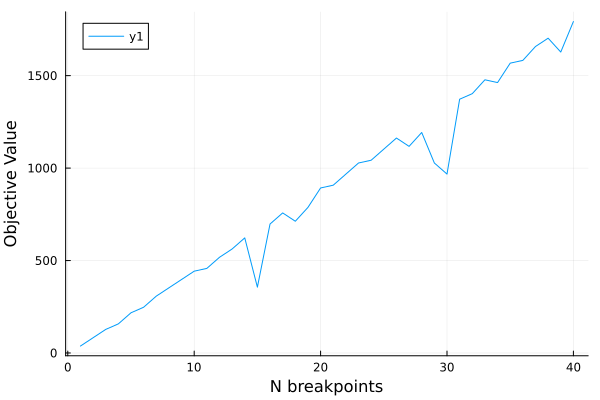

In [34]:
plot(results, xlabel="N breakpoints", ylabel="Objective Value")